In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from  joblib import dump, load
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Wholesale customers Data Set
Annual spending in monetary units of clients of a wholesale distributor
The dataset refers to clients of a wholesale distributor. It includes the annual spending in monetary units (m.u.) on diverse product categories
Source: UCI Wholesale customers Data Set

Data set link: https://www.kaggle.com/datasets/binovi/wholesale-customers-data-set


### Data Description:
**Channel**: Horeca (Hotel/Restaurant/Cafe or Retail channel (Nominal)

**Region** : Lisnon, Oporto or Other (Nominal)

**Fresh** : annual spending (m.u.) on fresh products (Continuous)

**Milk** : annual spending (m.u.) on milk products (Continuous)

**Grocery** : annual spending (m.u.)on grocery products (Continuous)

**Frozen** : annual spending (m.u.)on frozen products (Continuous)

**Detergents_Paper** : annual spending (m.u.) on detergents and paper products (Continuous)

**Delicassen** : annual spending (m.u.)on and delicatessen products (Continuous)

<br /><br />
Expected Output
- Multiple Dunn Index measures resembling corresponding the different k used for K-Means clustering the dataset.
- An output plot of the elbow curve.
- The best k chosen based on the elbow curve plot.
- Output predicted clusters for the first 10 data samples.

In [2]:
df_raw = pd.read_csv("Data/Wholesale_Customers_Data.csv")
df_raw.head(10)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
5,2,3,9413,8259,5126,666,1795,1451
6,2,3,12126,3199,6975,480,3140,545
7,2,3,7579,4956,9426,1669,3321,2566
8,1,3,5963,3648,6192,425,1716,750
9,2,3,6006,11093,18881,1159,7425,2098


### Look for NaN values and drop them

In [3]:
display(df_raw.info())
print("\n")
display(df_raw.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


None

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

## Cluster the data without considering the Channel and Region 

In [18]:
# Scale each column 
df = df_raw.copy()
for col in df:
    df.loc[:,col] = MinMaxScaler().fit_transform(df.loc[:,col].values.reshape(-1, 1))
    
X = df.drop(columns=['Channel', 'Region']).values

### Define objective funcions for hyperparameter tuning

In [19]:
# Objective function for hyperparameter tuning of DecisionTree
def objective(trial, X, n_clusters, random_state):
    params = {        
    "init": trial.suggest_categorical("init", ["k-means++", "random"]),
    "tol": trial.suggest_float("tol", 1e-9, 1e9, log=True),
    "algorithm": trial.suggest_categorical("algorithm", ["lloyd", "elkan"]),
    # Constants
    "n_clusters": trial.suggest_categorical("n_clusters", [n_clusters]),
    "n_init": trial.suggest_categorical("n_init", [10]),
    "max_iter": trial.suggest_categorical("max_iter", [1000]),
    "random_state": trial.suggest_categorical("random_state", [random_state]),
    }
    
    cluster_model = KMeans(**params).fit(X)
    silhouette_avg = silhouette_score(X, cluster_model.labels_)

    trial.set_user_attr("cluster_model", cluster_model)
    
    return silhouette_avg

In [20]:
random_state = 42
optuna.logging.set_verbosity(optuna.logging.INFO)
optuna.logging.set_verbosity(optuna.logging.WARNING)
best_score = 0
best_k = 2
best_trial = []
best_cluster_model  = []
silhouette_score_log = {'n_k':[], 'silhouette_score':[], 'sse':[]}
models_ls = []

for k in range(2,11):
    study = optuna.create_study(direction = "maximize")
    func = lambda trial: objective(trial, X, k, random_state)
    study.optimize(func, n_trials = 100, timeout=600)
    silhouette_score_val = study.best_trial.value

    cluster_model = study.best_trial.user_attrs['cluster_model']
    sse_val = cluster_model.inertia_
    silhouette_avg = silhouette_score(X, cluster_model.labels_)
    
    #print("K = ", k)
    #print("Silhouette Score = ", silhouette_score_val)
    silhouette_score_log['n_k'].append(k)
    silhouette_score_log['silhouette_score'].append(silhouette_score_val)
    silhouette_score_log['sse'].append(silhouette_score_val)

    if silhouette_score_val > best_score:
        best_score = silhouette_score_val
        best_k = k
        best_trial = study.best_trial
        best_cluster_model = cluster_model

Best Silhouette Score was = 0.62 with K equals to 2

First 10 sample labels are:  [1 1 1 1 1 1 1 1 1 1]
Best Score Params: 
    init: random
    tol: 0.8027843820552052
    algorithm: lloyd
    n_clusters: 2
    n_init: 10
    max_iter: 1000
    random_state: 42


<Axes: xlabel='n_k', ylabel='silhouette_score'>

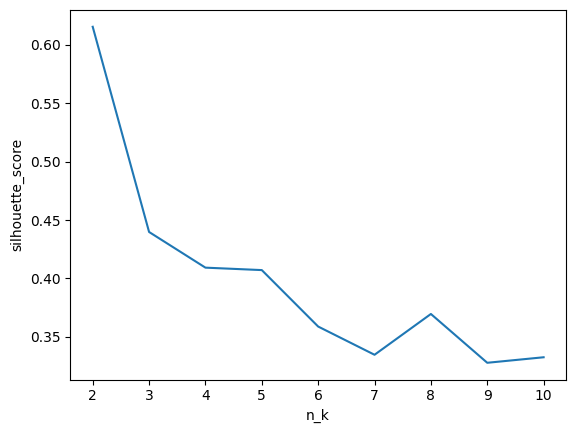

In [21]:
print(f"Best Silhouette Score was = {best_score:.2f} with K equals to {best_k}\n")
print("First 10 sample labels are: ", best_cluster_model.labels_[:10])

print("Best Score Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

sns.lineplot(data=pd.DataFrame(silhouette_score_log), x='n_k', y='silhouette_score')

## Combine the Channel and Region and then cluster the data again 

In [22]:
display(df_raw['Region'].unique())
display(df_raw['Channel'].unique())

array([3, 1, 2], dtype=int64)

array([2, 1], dtype=int64)

In [31]:
df = df_raw.copy()

df['Region_Chann'] = df['Region']+10*df['Channel']
df.drop(columns=['Channel', 'Region'], inplace=True)
df.head(10)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Region_Chann
0,12669,9656,7561,214,2674,1338,23
1,7057,9810,9568,1762,3293,1776,23
2,6353,8808,7684,2405,3516,7844,23
3,13265,1196,4221,6404,507,1788,13
4,22615,5410,7198,3915,1777,5185,23
5,9413,8259,5126,666,1795,1451,23
6,12126,3199,6975,480,3140,545,23
7,7579,4956,9426,1669,3321,2566,23
8,5963,3648,6192,425,1716,750,13
9,6006,11093,18881,1159,7425,2098,23


In [32]:
# Scale each column 
for col in df:
    df.loc[:,col] = MinMaxScaler().fit_transform(df.loc[:,col].values.reshape(-1, 1))
    
X = df.values

In [33]:
random_state = 42
optuna.logging.set_verbosity(optuna.logging.INFO)
optuna.logging.set_verbosity(optuna.logging.WARNING)
best_score = 0
best_k = 2
best_trial = []
best_cluster_model  = []
silhouette_score_log = {'n_k':[], 'silhouette_score':[], 'sse':[]}
models_ls = []

for k in range(2,11):
    study = optuna.create_study(direction = "maximize")
    func = lambda trial: objective(trial, X, k, random_state)
    study.optimize(func, n_trials = 100, timeout=600)
    silhouette_score_val = study.best_trial.value

    cluster_model = study.best_trial.user_attrs['cluster_model']
    sse_val = cluster_model.inertia_
    silhouette_avg = silhouette_score(X, cluster_model.labels_)
    
    #print("K = ", k)
    #print("Silhouette Score = ", silhouette_score_val)
    silhouette_score_log['n_k'].append(k)
    silhouette_score_log['silhouette_score'].append(silhouette_score_val)
    silhouette_score_log['sse'].append(silhouette_score_val)

    if silhouette_score_val > best_score:
        best_score = silhouette_score_val
        best_k = k
        best_trial = study.best_trial
        best_cluster_model = cluster_model

Best Silhouette Score was = 0.74 with K equals to 2

First 10 sample labels are:  [0 0 0 1 0 0 0 0 1 0]
Best Score Params: 
    init: k-means++
    tol: 0.017287822115632623
    algorithm: lloyd
    n_clusters: 2
    n_init: 10
    max_iter: 1000
    random_state: 42


<Axes: xlabel='n_k', ylabel='silhouette_score'>

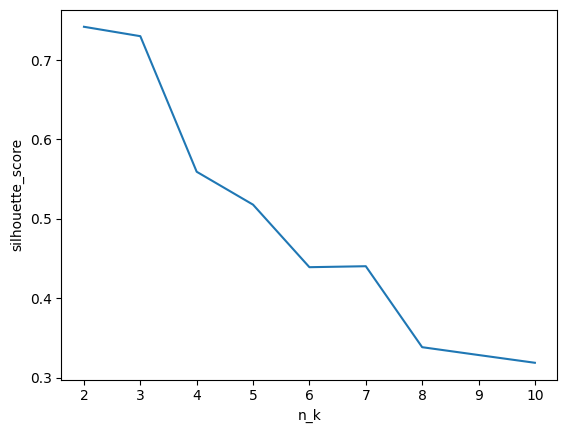

In [34]:
print(f"Best Silhouette Score was = {best_score:.2f} with K equals to {best_k}\n")
print("First 10 sample labels are: ", best_cluster_model.labels_[:10])

print("Best Score Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

sns.lineplot(data=pd.DataFrame(silhouette_score_log), x='n_k', y='silhouette_score')